# Capstone Project 1: Liver Disease Prediction
---
## Data Cleaning
### Nils Madsen
---

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load csv into dataframe and label columns
raw_df = pd.read_csv('indian_liver_dataset.csv', header=None)
raw_df.columns = ['age', 'sex', 'total bili', 'direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'albumin', 
                  'a-g ratio', 'group']

raw_df.head()

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,group
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        579 non-null float64
group            583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None


___
## Data Types

The data types in the raw data already look clean. There are no issues like numeric variables stored as strings. For performance purposes, the sex and group columns could be converted to categorical type. However, I plan to store the cleaned data as another csv file, so making that conversion here would be premature. 
___

In [4]:
# view the 4 rows that have NaN values for albumin-globulin ratio
raw_df.loc[pd.isnull(raw_df['a-g ratio']), :]

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,group
209,45,Female,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,Male,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,Female,0.6,0.2,180,12,15,5.2,2.7,NaN,2
312,27,Male,1.3,0.6,106,25,54,8.5,4.8,NaN,2


---
## Missing values

Since there are only 4 observations with incomplete information, dropping these observations is unlikely to bias the overall dataset in a meaningful way. However, only one variable is missing from these rows, so dropping the entire row seems like a waste of good data.

Another option is to drop the entire variable. However, this option is usually reserved for cases where a large portion of the field is missing. Also, removing an entire variable might reduce the effectiveness of machine learning.

Given the small number of missing values, and the goal of predicting the presence of liver disease, I believe the best way forward is to fill the missing values by imputing from the mean or median of the relevant liver disease group. This should give the machine learning algorithm slightly more data to learn from, while preserving the population distributions of the two groups.
___

count    414.000000
mean       0.914179
std        0.326153
min        0.300000
25%        0.700000
50%        0.900000
75%        1.100000
max        2.800000
Name: a-g ratio, dtype: float64
count    165.000000
mean       1.029576
std        0.287252
min        0.370000
25%        0.900000
50%        1.000000
75%        1.200000
max        1.900000
Name: a-g ratio, dtype: float64


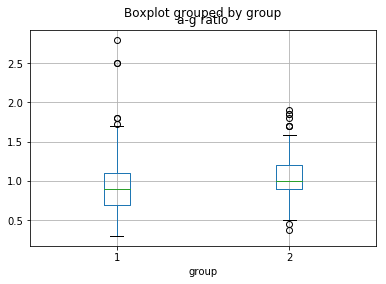

In [5]:
#investigate the distribution of a-g ratio to determine whether to use mean or median for imputation
print(raw_df.loc[raw_df['group']==1, 'a-g ratio'].describe())
print(raw_df.loc[raw_df['group']==2, 'a-g ratio'].describe())
raw_df.boxplot('a-g ratio', by='group')
plt.show()
plt.gcf().clear()

___
There are some outliers in the a-g ratio variable, but the mean and median are very close in value in both groups. The difference is likely to be minimal, so I will use the mean for the imputation.
___

In [6]:
# impute missing values
liver_df = raw_df.copy()
liver_df.loc[liver_df['a-g ratio'].isnull(), 'a-g ratio'] = liver_df.groupby('group')['a-g ratio'].transform('mean')
print(liver_df.info())

# check that only the previously NaN rows have been changed
print(raw_df.head(5))
print(liver_df.head(5))
print(raw_df.iloc[[209, 241, 253, 312],:])
print(liver_df.iloc[[209, 241, 253, 312],:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
group            583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None
   age     sex  total bili  direct bili  ALP  ALT  AST  total protein  \
0   65  Female         0.7          0.1  187   16   18            6.8   
1   62    Male        10.9          5.5  699   64  100            7.5   
2   62    Male         7.3          4.1  490   60   68            7.0   
3   58    Male         1.0          0.4  182   14   20            6.8   
4   72    Male         3.9          2.0  195   27   59 

In [7]:
# check for duplicate rows
liver_df.duplicated().sum()

13

___
## Duplicate Rows

There are 13 duplicate rows in the data set. Unfortunately, there is no column giving a unique identifier for each patient, so there is no way to determine whether these rows are actually duplicated, or if they refer to multiple patients who happened to have exactly the same measures along all the variables. Because of this, I will elect to trust the original data set and include the duplicate rows.
___

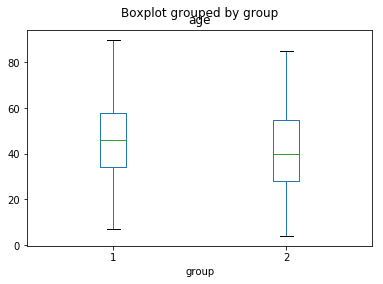

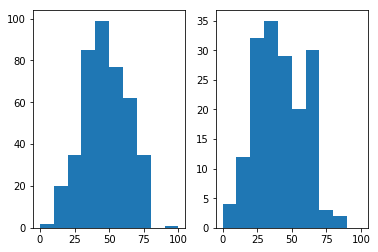

In [29]:
#check for outliers
liver_df.boxplot('age', by='group', grid=False)
plt.show()

plt_range = (0, 100)
plt_bins = 10
plt.subplot(1, 2, 1)
plt.hist(liver_df.age[liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df.age[liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

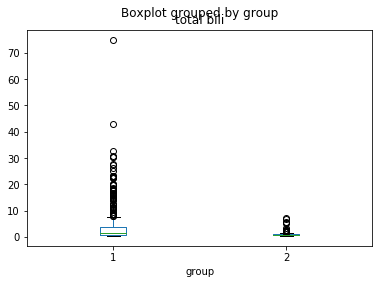

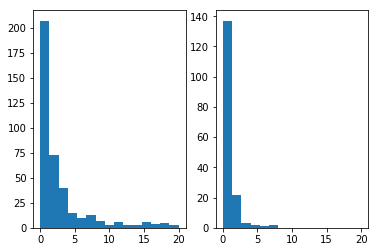

In [40]:
liver_df.boxplot('total bili', by='group', grid=False)
plt.show()

plt_range = (0, 20)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['total bili'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['total bili'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

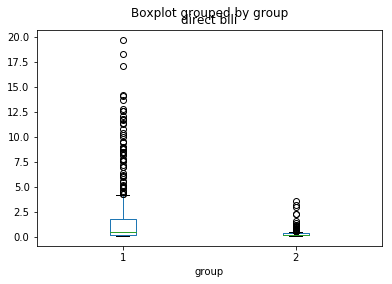

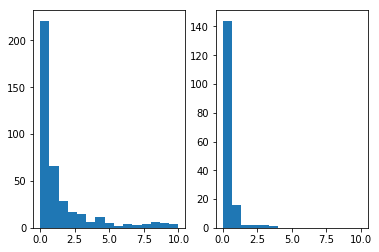

In [39]:
liver_df.boxplot('direct bili', by='group', grid=False)
plt.show()

plt_range = (0, 10)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['direct bili'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['direct bili'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

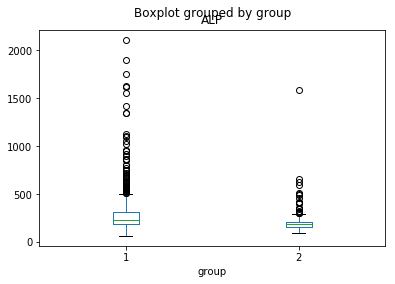

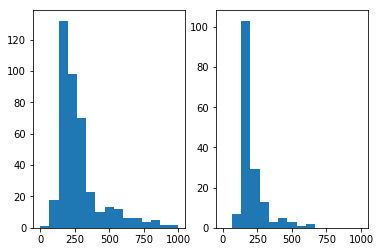

In [41]:
liver_df.boxplot('ALP', by='group', grid=False)
plt.show()

plt_range = (0, 1000)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['ALP'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['ALP'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

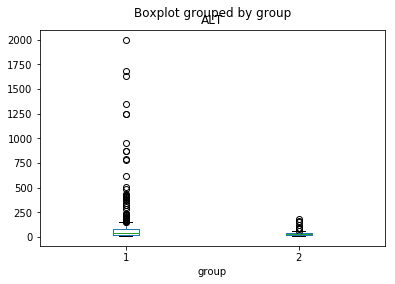

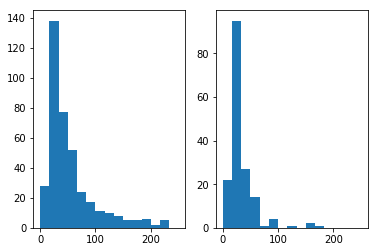

In [36]:
liver_df.boxplot('ALT', by='group', grid=False)
plt.show()

plt_range = (0, 250)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['ALT'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['ALT'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

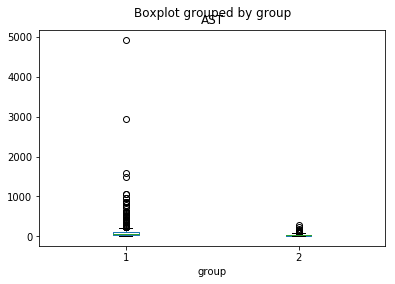

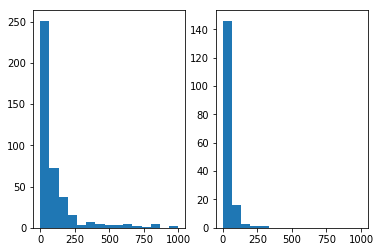

In [43]:
liver_df.boxplot('AST', by='group', grid=False)
plt.show()

plt_range = (0, 1000)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['AST'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['AST'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

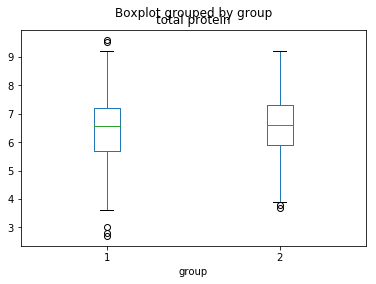

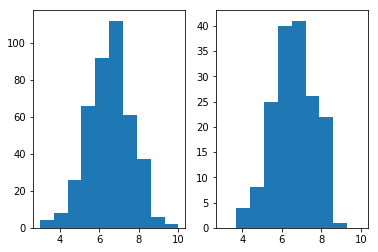

In [45]:
liver_df.boxplot('total protein', by='group', grid=False)
plt.show()

plt_range = (3, 10)
plt_bins = 10
plt.subplot(1, 2, 1)
plt.hist(liver_df['total protein'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['total protein'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

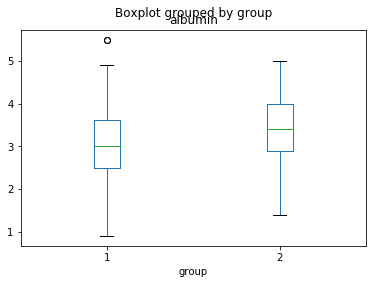

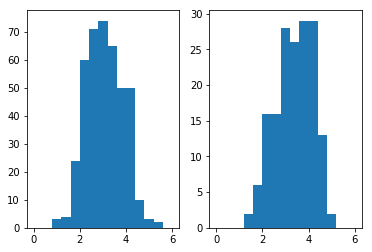

In [25]:
liver_df.boxplot('albumin', by='group', grid=False)
plt.show()

plt_range = (0, 6)
plt_bins = 15
plt.subplot(1, 2, 1)
plt.hist(liver_df['albumin'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['albumin'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

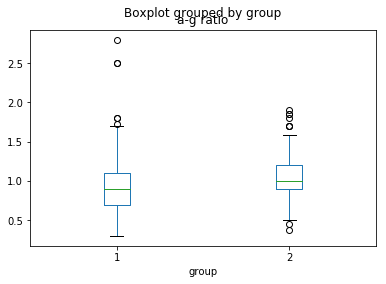

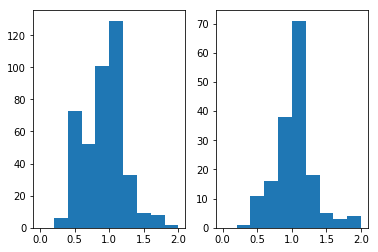

In [47]:
liver_df.boxplot('a-g ratio', by='group', grid=False)
plt.show()

plt_range = (0, 2)
plt_bins = 10
plt.subplot(1, 2, 1)
plt.hist(liver_df['a-g ratio'][liver_df.group==1], bins=plt_bins, range=plt_range)

plt.subplot(1, 2, 2)
plt.hist(liver_df['a-g ratio'][liver_df.group==2], bins=plt_bins, range=plt_range)
plt.show()
plt.gcf().clear()

___
## Outliers

A significant amount of outliers are present in the total bilirubin, direct bilirubin, ALP, AST, and ALT columns. While this might be alarming in other types of data, the presence of outliers in these measures is not surprising, and is in fact expected in data on liver disease. This is because these measures are of molecules that are normally kept at low concentrations in the blood. When the liver becomes damaged, these measures can rise by orders of magnitude, because there is a failure in the body's ability to keep them low. In addition, the scale of the increase in certain markers is used by doctors to predict what kind of liver disease is present. For example, an ALT score in the 100-200 range might indicate alcoholic or fatty liver, while a measure in the thousands could point to viral hepatitis or poisoning.

A lesser amount of outliers are present in total protein, albumin, and a-g ratio. It is not clear what justification could be made for removing them, and the outliers are not dramatically larger or smaller in these fields, as are the outliers for bilirubin and the liver enzymes. 

For these reasons, I believe it is best to include all outliers in the data set.
___

In [17]:
# store the cleaned data in a new csv
liver_df.to_csv('indian_liver_dataset_clean.csv')